# Fit atmospheric parameters - No Filter date 2023/03/16 PSF2DFFM REBIN2

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : April 8th 2023
- last update : April 8th 2023

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle
import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import RegularGridInterpolator

In [7]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
#from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

In [9]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [10]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [11]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

In [12]:
os.getenv("PYSYN_CDBS")

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [13]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
                   }         

In [14]:
# Must divide the observed flux by this correction area
correction_area = 1.06/1.13

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [15]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [16]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [17]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [18]:
def GetSpectra(dict_spectra,factor=1.):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area*factor 
        df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area*factor 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [19]:
def GetColumnHfData(hf,list_of_keys,nameval):
    """
    Extract h5file atttribute 
    
    parameters
      hf           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
      the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hf.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data

In [20]:
def reorder(df,all_subgroup_keys):
    
    if 'me_az_rms' in all_subgroup_keys:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                         "me_az_rms",
                         "me_el_rms",
                         "me_rot_rms",
                         "me_image_az_rms",
                         "me_image_el_rms",
                         "me_image_rot_rms",
                        ])
    else:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                        ])
        
    return df
        

In [21]:
def GetSpectraH5(h5spectra,factor=1.):
    """
    GetSpectraH5(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    #d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opt
    
    idx=0
    for key in sorted_spectra_keys :
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
    return df_info , all_df

In [22]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [23]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [24]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

In [25]:
class SimpleAtmEmulator:
    """
    Emulate Atmospheric Transparency above LSST from a data grids
    extracted from libradtran and analytical functions for aerosols.
    There are 3 grids:
    - 2D grid Rayleigh transmission vs (wavelength,airmass)
    - 2D grid O2 absorption vs  (wavelength,airmass)
    - 3D grid for PWV absorption vs (wavelength,airmass,PWV)
    - 3D grid for Ozone absorption vs (wavelength,airmass,Ozone)
    - Aerosol transmission for any number of components
    
    """
    def __init__(self,path='../data/simplegrid'):
        """
        Initialize the class for data point files from which the 2D and 3D grids are created.
        Interpolation are calculated from the scipy RegularGridInterpolator() function
        
        """
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']
        
        
        self.lambda0 = 550.
        self.tau0 = 1.


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        """
        Load files into grid arrays
        """
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)
            
            
            
    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ (the_wl,am,pwv) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ (the_wl,am,oz) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_OZabs_train(pts)
            
            
    
  
    
    def GetGriddedTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):
        """
        Emulation of libradtran simulated transparencies. Decomposition of the
        total transmission in different processes:
        - Rayleigh scattering
        - O2 absorption
        - PWV absorption
        - Ozone absorption
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
            
        if flagRayleigh:
            transm = self.GetRayleighTransparencyArray(wl,am)
        else:
            transm = np.ones(len(wl))
            
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        return transm
            
    def GetAerosolsTransparencies(self,wl,am,ncomp,taus=None,betas=None):
        """
        Compute transmission due to aerosols:
        
        inputs:
        - wl : wavelength array
        - am : the airmass
        - ncomp : the number of aerosol components
        - taus : the vertical aerosol depth of each component at lambda0 vavelength
        - betas : the angstrom exponent. Must be negativ.
        
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
          
        wl = np.array(wl)
        NWL=wl.shape[0]
        
        transm = np.ones(NWL)
        
        if ncomp <=0:
            return transm
        else:
            taus=np.array(taus)
            betas=np.array(betas)
            
            NTAUS=taus.shape[0]
            NBETAS=betas.shape[0]
        
            assert ncomp<=NTAUS
            assert ncomp<=NBETAS     
        
            for icomp in range(ncomp):            
                exponent = (taus[icomp]/self.tau0)*np.exp(betas[icomp]*np.log(wl/self.lambda0))*am
                transm *= np.exp(-exponent)
            
            return transm
        
        
    def GetAllTransparencies(self,wl,am,pwv,oz,ncomp=0, taus=None, betas=None, flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True,flagAerosols=False):
        """
        Combine interpolated libradtran transmission with analytical expression for the
        aerosols
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - ncomp : number of aerosols components,
        - taus & betas : arrays of parameters for aerosols
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
        
        transm = self.GetGriddedTransparencies(wl,am,pwv,oz,flagRayleigh=flagRayleigh,flagO2abs=flagO2abs,flagPWVabs=flagPWVabs,flagOZabs=flagOZabs)
        
        if flagAerosols:
            transmaer = self.GetAerosolsTransparencies(wl,am,ncomp,taus,betas)
            transm *=transmaer
           
            
        return transm
            

# Constants

# Initialisation

In [26]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [27]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-04-08 18:00:07,629 MacBook-Pro-de-admin.local __main__[73763] INFO LA time:09:00:07
2023-04-08 18:00:07,631 MacBook-Pro-de-admin.local __main__[73763] INFO NY time:12:00:07
2023-04-08 18:00:07,634 MacBook-Pro-de-admin.local __main__[73763] INFO London time:17:00:07
2023-04-08 18:00:07,637 MacBook-Pro-de-admin.local __main__[73763] INFO Paris time:18:00:07
2023-04-08 18:00:07,637 MacBook-Pro-de-admin.local __main__[73763] INFO ************************ START *********************


In [28]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [29]:
! ls config/20230316/empty~holo4_003

confprog_run-auxtel-20230316-empty~holo4_003_psf2dffm_rebin2.ini


In [30]:
DATE = 20230316
FILTERTYPE = "empty~holo4_003"
spectractormode = "psf2dffm"
ext = "rebin2"   # run BPS by removing ACQ

In [31]:
# config file
# --------------
#configfile = "config/default.ini"
if ext == None or ext == "":
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}.ini"
else:
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}_{ext}.ini"
    
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-04-08 18:00:07,810 MacBook-Pro-de-admin.local __main__[73763] INFO Configuration file : config/20230316/empty~holo4_003/confprog_run-auxtel-20230316-empty~holo4_003_psf2dffm_rebin2.ini


In [32]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-04-08 18:00:07,819 MacBook-Pro-de-admin.local __main__[73763] INFO 1) Configuration


In [33]:
config_section = config.sections()

In [34]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [35]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
   
    spectractormode = config['GENERAL']['spectractormode']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [36]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [37]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[]

In [38]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [39]:
path_calspec

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec'

In [40]:
dict_f_sed = {}
dict_name_sed = {}

In [41]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10*normalisationfactor
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.


In [42]:
dict_name_sed

{'HD38666': 'MUCOL',
 'HD185975': 'HD185975',
 'HD074000': 'HD074000',
 'HD60753': 'HD60753',
 'HD111980': 'HD111980',
 'HD37962': 'HD37962',
 'HD031128': 'HD031128',
 'HD14943': 'HD14943',
 'HD38949': 'HD38949'}

In [43]:
sed_m=-2.5*np.log10(sed_f)

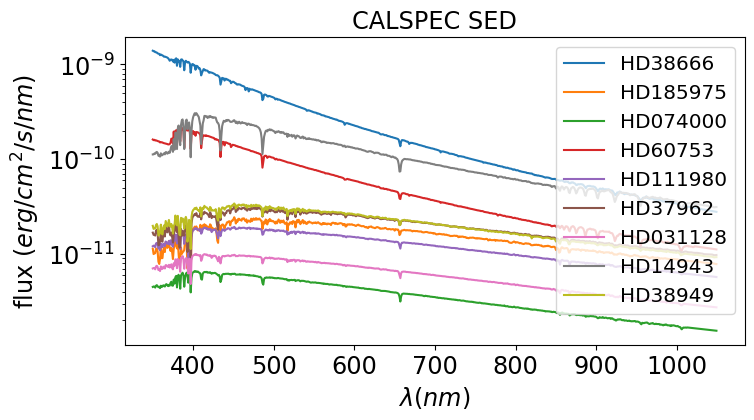

In [44]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

# Throughputs

## Auxtel throughput and  telescope throughput

In [45]:
array = np.loadtxt(filename_auxtelthroughput)
dft = pd.DataFrame(data=array,columns=["lambda","throughput"])

In [46]:
#dft = pd.read_excel(filename_auxtelthroughput,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

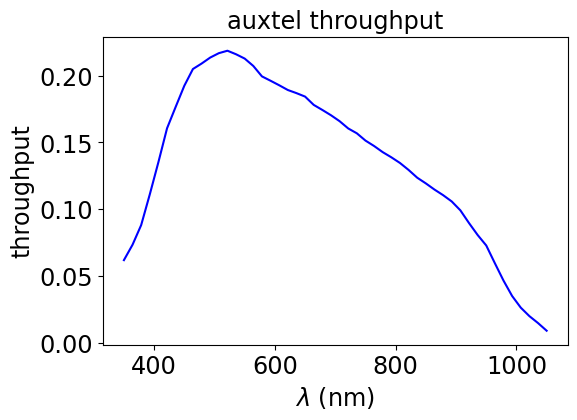

In [47]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [48]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## spectrum data

In [49]:
fullfilename = os.path.join(inputdir,inputfile)

In [50]:
#with open(fullfilename, 'rb') as f:
#    summary_content = pickle.load(f)

In [51]:
hf =  h5py.File(fullfilename, 'r') 
list_of_keys = list(hf.keys())

In [52]:
NBSPECTRA=len(list_of_keys)

In [53]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-04-08 18:00:09,337 MacBook-Pro-de-admin.local __main__[73763] INFO  Number of selected files is 60


In [54]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [55]:
normalisationfactor

1.0

In [56]:
#infos, all_spectra = GetSpectra(summary_content,factor = normalisationfactor)
infos, all_spectra = GetSpectraH5(hf,factor = normalisationfactor)

In [68]:
def get_seq(row):
    return row - (row//100000)*100000
infos["number"] = infos[['exposure']].apply(lambda x: get_seq(x))


In [62]:
N=len(infos)

In [63]:
NX=4
NY=N/NX

In [64]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

In [70]:
infos.head()

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,...,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,me_az_rms,me_el_rms,me_rot_rms,me_image_az_rms,me_image_el_rms,me_image_rot_rms,number
0,0,2023031600465,2023-03-17T06:20:56.082001145Z,HD185975,empty,2.034006,0,0,0,-107.983587,...,22666.666667,1136,185,0.015520,0.013880,0.103779,0.013527,0.013880,0.000141,465
1,1,2023031600466,2023-03-17T06:21:39.074005228Z,HD185975,empty,2.033523,0,0,0,-107.803713,...,22666.666667,1137,185,0.012167,0.017075,0.082188,0.010604,0.017075,0.000112,466
2,2,2023031600473,2023-03-17T06:26:56.797507884Z,HD73495,empty,2.078695,0,0,0,70.828853,...,22666.666667,1137,185,0.025879,0.149034,0.113203,0.022707,0.149034,0.000154,473
3,3,2023031600474,2023-03-17T06:27:39.839499093Z,HD73495,empty,2.088588,0,0,0,71.008674,...,22666.666667,1137,185,0.023807,0.095927,0.094171,0.020920,0.095927,0.000128,474
4,4,2023031600488,2023-03-17T06:41:00.247501554Z,HD111980,empty,1.034627,0,0,0,10.525123,...,22666.666667,1137,185,0.384949,0.035174,0.299879,0.098839,0.035174,0.000407,488


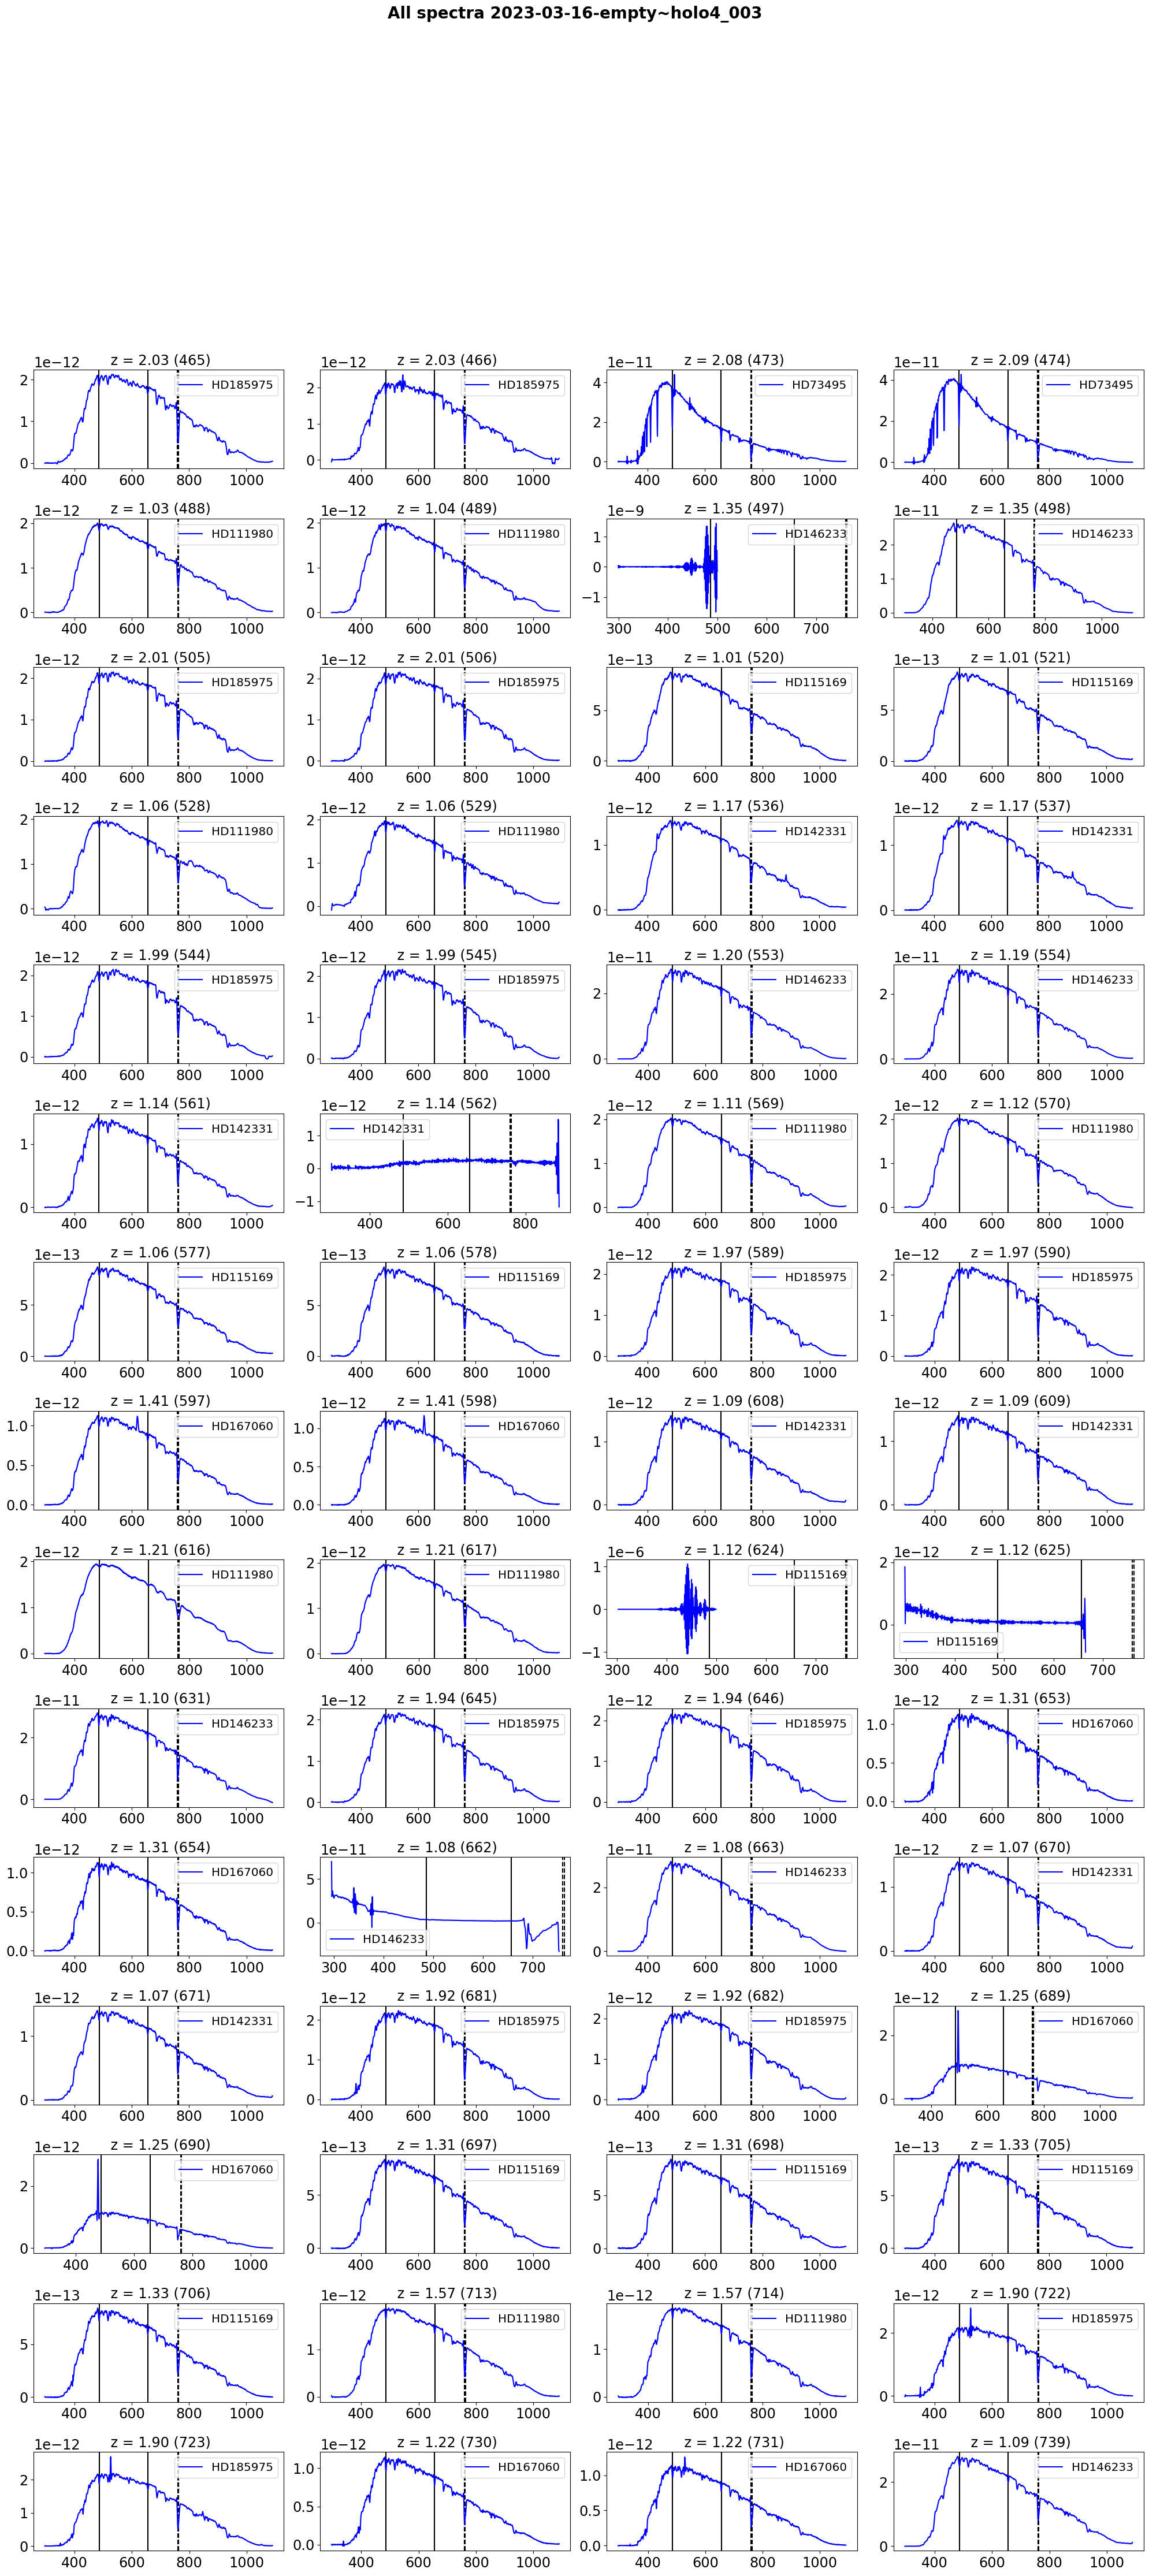

In [71]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["spec_airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["spec_target_label"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
    
the_title = f"All spectra {DATE}-{filterdisperser}"

plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_01-{DATE}-{filterdisperser}-allspectra.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

In [ ]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [ ]:
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182))
bad_cut = ~selection_cut

In [ ]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

#### No SED for HD42525

In [ ]:
selection_cut3 = infos.object == "HD42525" 
list_of_badnum3 = infos[selection_cut3]["number"].values

# Union of badnums

In [ ]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums = np.union1d(list_of_badnums,list_of_badnum3)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [ ]:
list_of_badnums

In [ ]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums,factor = normalisationfactor)

In [ ]:
print("Number of spectra : ",len(all_spectra))

In [ ]:
infos.reset_index(drop=True, inplace=True)

In [ ]:
infos

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target after spectra selection ")

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2023, 1, 31, 0, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
the_title = f"All spectra airmass {DATE}-{filterdisperser}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_02-{DATE}-{filterdisperser}-airmasses.pdf"
plt.savefig(fig_filename)
plt.show()

# Simulate atmospheric transparency

In [ ]:
emul = SimpleAtmEmulator()

In [ ]:
NBINFOS = len(infos)
dict_func_atm = {}
print(NBINFOS)

pwv0 = 3
oz0 = 300.
ncomp=0

for ispec in range(NBINFOS):
    the_infos = infos.iloc[ispec]
    the_airmass = the_infos["airmass"]
    the_number = the_infos["number"]
    
    transm = emul.GetAllTransparencies(WL,the_airmass,pwv0,oz0,ncomp=ncomp,flagAerosols=False)
    dict_func_atm[the_number] = interpolate.interp1d(WL,transm,bounds_error=False,fill_value="extrapolate")

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBINFOS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBINFOS), alpha=1)

In [ ]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for isim in np.arange(NBINFOS):
    
    airmassvalue = infos.iloc[isim]["airmass"]
    the_number = infos.iloc[isim]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    atm = dict_func_atm[the_number](WL)
    
    ax.plot(WL,atm, color=all_colors[isim],label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("air transparency")
title=f"sim. tmospheric transparencies({DATE}) pwv = {pwv0:.2f} mm oz = {oz0:.0f} DU"
ax.set_title(title,fontsize=20,fontweight='bold')

ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(0.,1)
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Plot Spectra

In [ ]:
NBSPECTRA=len(all_spectra)

In [ ]:
assert NBSPECTRA == NBINFOS

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [ ]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

### load absorption pattern

In [ ]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [ ]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

In [ ]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


#gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,4] ,figure=fig)
gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,4] ,figure=fig)

#=========================================================== NO2    
#ax=fig.add_subplot(gs[0,0])
#for index in np.arange(NOBS):   
#    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
#ax.set_ylim(0.8,1)
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.grid()
#textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
#ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax.set_title(title,fontsize=20,fontweight='bold')
#main_ax = ax



#=========================================================== O2    
#ax=fig.add_subplot(gs[0,0], sharex=main_ax)
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)
main_ax = ax

#=========================================================== Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#=========================================================== H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#================================================= spectra
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
all_numbers = infos['number'].values



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
#ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=6)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)

plt.tight_layout()


In [ ]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

    f_flux = interpolate.interp1d(the_df["all_lambdas"].values,the_df['all_fluxes'].values,bounds_error=False,fill_value=0)
    x1=1000.
    y1=f_flux(x1)
    s1=str(the_number)
    x2=600
    y2=f_flux(x2)
    s2=infos.iloc[ifile]["object"]
    ax.text(x1+5, y1, s1, color=all_colors[ifile],fontsize=12)
    ax.text(x2+15, y2*1.1, s2, color=all_colors[ifile],fontsize=14)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


In [ ]:
correction_area = 1.06/1.13

In [ ]:
#sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) 
#sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

# Fit

## Select the identifier

In [ ]:
dict_ratio = {}
array_ratio = np.zeros((NBSPECTRA,len(WL)))

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])

    # extract spectrum from data
    the_df=all_spectra[idx]
    the_number = infos.iloc[idx]["number"]
    airmassvalue = infos.iloc[idx]["airmass"]
    target = infos.iloc[idx]["object"]
    label_airmass = f" {target}({the_number}) : z = {airmassvalue:.2f}"

    # the SED
    f_sed = dict_f_sed[target] 

    # atmosphere
    the_f_atm = dict_func_atm[the_number]

    # the throughput
    #f_thr

    # prediction
    the_wl = the_df["all_lambdas"].values
    the_sim = f_sed(the_wl) * the_f_atm(the_wl) * f_thr(the_wl)


    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(the_wl,the_sim,'-r')

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Obs Spectr from {target} at {SITE} ({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    

    main_ax = ax

    # Fig 2
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ax.errorbar(the_wl,the_df['all_fluxes']/correction_area/the_sim,yerr=the_df["all_fluxes_err"], fmt = '.',color="g",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ratio = the_df['all_fluxes']/correction_area/the_sim
    
    # remove absorption line
    xcut1=758
    xcut2=767
    xcut3=925
    xcut4=970
    
    index_to_remove=np.where(np.logical_or(np.logical_and(the_wl>xcut1,the_wl<xcut2),np.logical_and(the_wl>xcut3,the_wl<xcut4)))[0]
    
                             
    new_the_wl = the_wl[~np.isin(np.arange(the_wl.size), index_to_remove)]
    new_ratio = ratio[~np.isin(np.arange(ratio.size), index_to_remove)]
    
    f_ratio = interpolate.interp1d(new_the_wl,new_ratio,bounds_error=False,fill_value="extrapolate")
    ratio_interp =f_ratio(WL)
    
                                
    ax.plot(WL,ratio_interp,'.',color="purple")

    span=30
    ratio_filtered = smooth_data_np_convolve(ratio_interp,span)
    ax.plot(WL,ratio_filtered,'k-',lw=3)
    
    
    dict_ratio[the_number] = ratio_filtered
    array_ratio[idx,:] = ratio_filtered
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='r')
    
    ax.axvline(x=930,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=970,linewidth=2,linestyle=':', color='r')

    ax.grid()
    ax.set_ylim(0,2)
    ax.set_ylabel("ratio data/sim")
    
    plt.show()



### Compute the median ratio

In [ ]:
ratio_median = np.median(array_ratio,axis=0)

In [ ]:
hls_colors = sns.color_palette("hls", NBSPECTRA)

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

idx=0
for key, value in dict_ratio.items():
    ax.plot(WL,value,"-",color=hls_colors[idx],lw=2)
    idx+=1
    
ax.plot(WL,ratio_median,'k-',lw=3)
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("ratio")
ax.set_title("ratio data/sim")
ax.grid()

#### Compute the error ratio_median_error  

In [ ]:
ratio_median_error  = np.std(array_ratio-ratio_median,axis=0) 

In [ ]:
hls_colors = sns.color_palette("hls", NBSPECTRA)

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

idx=0
for key, value in dict_ratio.items():
    ax.plot(WL,value,"-",color=hls_colors[idx],lw=1,alpha=0.5)
    idx+=1
    
ax.errorbar(WL,ratio_median,yerr=ratio_median_error ,fmt='.',color='k',ecolor="grey",lw=1,alpha=1.0)


ax.set_ylim(0,1)
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("ratio")
ax.set_title("ratio data/sim with error bars")

ax.grid()
ax.legend()

### New measured throughput

In [ ]:
hls_colors = sns.color_palette("hls",2)

new_throughput = f_thr(WL)*ratio_median
new_throughput_error = f_thr(WL)*ratio_median_error

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
ax.plot(WL,f_thr(WL),'b-',label = "old Auxtel transmission",lw=2) 
ax.plot(WL,new_throughput,'r-',label = "new Auxtel transmission",lw=2)
ax.errorbar(WL,new_throughput,yerr=new_throughput_error ,fmt='.',color='r',ecolor="grey",lw=1,alpha=1)

ax.plot(WL,2*new_throughput,'g-',label = "new Auxtel transmission x 2",lw=2)
ax.errorbar(WL,2*new_throughput,yerr=new_throughput_error ,fmt='.',color='g',ecolor="grey",lw=1,alpha=1)
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("throughput")

ax.set_title(f"Auxtel Throughput {DATE} - {filterdisperser} {spectractormode}")
ax.set_ylim(0,.25)

#### Save new throuthput in a file

In [ ]:
df_th_out = pd.DataFrame()
df_th_out["wavelength"] = WL
df_th_out["newthrou"] = new_throughput
df_th_out["newthrouerr"] = new_throughput_error
df_th_out["oldthrou"] = f_thr(WL)

In [ ]:
df_th_out

In [ ]:
filename_newthroughput = f"throughput-{DATE}-{filterdisperser}-{spectractormode}-fitatmparams.csv"

In [ ]:
df_th_out.to_csv(filename_newthroughput)

## New fittable 

In [ ]:
f_thr_new = interpolate.interp1d(WL,new_throughput,bounds_error=False,fill_value="extrapolate")

In [ ]:
dict_ratio = {}
array_ratio = np.zeros((NBSPECTRA,len(WL)))

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])

    # extract spectrum from data
    the_df=all_spectra[idx]
    the_number = infos.iloc[idx]["number"]
    airmassvalue = infos.iloc[idx]["airmass"]
    target = infos.iloc[idx]["object"]
    label_airmass = f" {target}({the_number}) : z = {airmassvalue:.2f}"

    # the SED
    f_sed = dict_f_sed[target] 

    # atmosphere
    the_f_atm = dict_func_atm[the_number]

    # the throughput
    #f_thr

    # prediction
    the_wl = the_df["all_lambdas"].values
    the_sim = f_sed(the_wl) * the_f_atm(the_wl) * f_thr_new(the_wl)


    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(the_wl,the_sim,'r-',lw=2)

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Obs Spectr from {target} at {SITE} ({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    

    main_ax = ax

    # Fig 2
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ax.errorbar(the_wl,the_df['all_fluxes']/correction_area/the_sim,yerr=the_df["all_fluxes_err"], fmt = '.',color="g",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ratio = the_df['all_fluxes']/correction_area/the_sim
    
    # remove absorption line
    xcut1=758
    xcut2=767
    xcut3=925
    xcut4=970
    
    index_to_remove=np.where(np.logical_or(np.logical_and(the_wl>xcut1,the_wl<xcut2),np.logical_and(the_wl>xcut3,the_wl<xcut4)))[0]
    
                             
    new_the_wl = the_wl[~np.isin(np.arange(the_wl.size), index_to_remove)]
    new_ratio = ratio[~np.isin(np.arange(ratio.size), index_to_remove)]
    
    f_ratio = interpolate.interp1d(new_the_wl,new_ratio,bounds_error=False,fill_value="extrapolate")
    ratio_interp =f_ratio(WL)
    
                                
    ax.plot(WL,ratio_interp,'.',color="purple")

    span=30
    ratio_filtered = smooth_data_np_convolve(ratio_interp,span)
    ax.plot(WL,ratio_filtered,'k-',lw=3)
    
    
    dict_ratio[the_number] = ratio_filtered
    array_ratio[idx,:] = ratio_filtered
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='r')
    
    ax.axvline(x=930,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=970,linewidth=2,linestyle=':', color='r')

    ax.grid()
    ax.set_ylim(0,2)
    ax.set_ylabel("ratio data/sim")
    
    plt.show()



# Do the fit

https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

In [ ]:
idx = 2
the_df=all_spectra[idx]
data = the_df['all_fluxes']/correction_area
dataerr = the_df["all_fluxes_err"]/correction_area
data_the_wl = the_df["all_lambdas"].values

index_sel= np.where(np.logical_and(data_the_wl>WLMINSEL,data_the_wl<WLMAXSEL))[0]

data = data[index_sel].values
dataerr = dataerr[index_sel].values 
data_the_wl = data_the_wl[index_sel]
                    
data_airmassvalue = infos.iloc[idx]["airmass"]
data_target = infos.iloc[idx]["object"]
f_sed = dict_f_sed[data_target] 
data_the_sedxthroughput = f_sed(data_the_wl) * f_thr_new(data_the_wl)

In [ ]:
# scipy.optimize.least_squares
#(fun, 
# x0, 
# jac='2-point', 
# bounds=(-inf, inf), 
# method='trf', 
# ftol=1e-08, 
# xtol=1e-08, 
# gtol=1e-08, 
# x_scale=1.0, 
# loss='linear', 
# f_scale=1.0, 
# diff_step=None, 
# tr_solver=None, 
# tr_options={}, 
# jac_sparsity=None, 
# max_nfev=None, 
# verbose=0, 
# args=(), 
# kwargs={})
#Function which computes the vector of residuals, with the signature fun(x, *args, **kwargs), 

In [ ]:
def pred(params,*x):
    
    global emul
    
    alpha,pwv,oz = params    
    
    # have to build the wavelength array as follow (I don't know why)
    wl = []
    for el in x[0]:
        wl.append(el)

    fl = alpha*emul.GetAllTransparencies(wl ,data_airmassvalue,pwv,oz,ncomp=0,flagAerosols=False)
    fl *= data_the_sedxthroughput
    return fl
       

def func_residuals(params):
    alpha,oz,pwv = params
    residuals = (data - pred(params,data_the_wl))/dataerr
    return residuals

In [ ]:
pwv0 = 3.0
oz0 = 300.
params0 = np.array([1,pwv0,oz0],dtype=object)

In [ ]:
print(repr(data_the_wl[:5]))

In [ ]:
res = least_squares(func_residuals, params0,bounds=([0.1,0.001,50.],[2,9.5,550.]))

In [ ]:
res

In [ ]:
def pred2(params,*arg):
    """
    Model prediction y = f(x) where x is the array of wavelength and y the measured flux
    
    inputs:
      - params : the unknown atmospheric parameters to fit (pwv,oz)
      - *args  : additionnal data provided to compute the model : 
                   1) the wavelength array, 
                   2) sedxthroughput,
                   3) the airmass
      
    output:
      - the array of predicted flux values at each wavelength data point
      
    It computes the production of the atmospheric transparency by the SED - throughout product  
    It makes use of the atmospheric model transparency emulated in the external global object emul 
    which depend on atmospheric parameters to fit
    
    """
    
    global emul
    
    alpha,pwv,oz = params    
    
    # have to build the wavelength array as follow (I don't know why)
    wl = []
    for el in arg[0]:
        wl.append(el)

    the_sedxthroughput = arg[1]
    
    airmass = arg[2]
        

    fl = alpha*emul.GetAllTransparencies(wl ,airmass,pwv,oz,ncomp=0,flagAerosols=False)
    fl *= the_sedxthroughput
    return fl
       

def func_residuals2(params,*arg):
    """
    This function is called by the scipy.optimize.least_squares function to compute the normalized residuals
    at each data point at each wavelength (yi-f(xi,thetaj)/sigmai
    
    input:
      - params : the unknown atmospheric parameters to fit (pwv,oz)
      - *args  : additionnal data provided to compute the mode : 
                 to the model
                   1) the wavelength array, 
                   2) sedxthroughput,
                   3) the airmass
                used to compute the residuals
                   4) data : the measured fluxes
                   5) dataerr : the error on fluxes
    
    return:
      - the array of residuals for the given set of parameters required by the least_squares function 
    """
    
    the_wl = arg[0]         # wavelength array required by the model function pred2
    the_sedthr = arg[1]     # the product of the SED by the throughput required by the model function pred2
    the_airmass = arg[2]    # the airmass required by the model function pred2 
    the_data = arg[3]       # the observed fluxes array
    the_dataerr = arg[4]    # the error on the observed fluxes array
    
     
    alpha,oz,pwv = params   # decode the parameters
    residuals = (the_data - pred2(params,the_wl,the_sedthr,the_airmass))/the_dataerr
    
    return residuals

In [ ]:
res2 = least_squares(func_residuals2, params0,bounds=([0.1,0.001,50.],[2,9.5,550.]),args=[data_the_wl,data_the_sedxthroughput,data_airmassvalue,data,dataerr])

In [ ]:
res2

## Loop on fits

In [ ]:
# extract spectrum from data
dict_fit = OrderedDict()

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(1, 1,height_ratios=[1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])
    
    
    the_df=all_spectra[idx]
    data = the_df['all_fluxes']/correction_area
    dataerr = the_df["all_fluxes_err"]/correction_area
    data_the_wl = the_df["all_lambdas"].values

    index_sel= np.where(np.logical_and(data_the_wl>WLMINSEL,data_the_wl<WLMAXSEL))[0]

    data = data[index_sel].values
    dataerr = dataerr[index_sel].values 
    data_the_wl = data_the_wl[index_sel]
                    
    data_airmassvalue = infos.iloc[idx]["airmass"]
    data_target = infos.iloc[idx]["object"]
    data_number = infos.iloc[idx]["number"]
    
    f_sed = dict_f_sed[data_target] 
    data_the_sedxthroughput = f_sed(data_the_wl) * f_thr_new(data_the_wl)

    label_airmass = f" {data_target}({data_number}) : z = {data_airmassvalue:.2f}"
    
    print(f"======================================= {idx} :{label_airmass} =================================")
    
    # Compute the fit of the parameters (alpha,pwv,oz)
    res2 = least_squares(func_residuals2, params0, bounds=([0.1,0.001,50.],[2,9.5,550.]),
                                                           args=[data_the_wl,data_the_sedxthroughput,data_airmassvalue,data,dataerr])
    
    alpha_fit,pwv_fit,oz_fit = res2.x
    
    
    # results fo the fit
    popt= res2.x
    J = res2.jac
    pcov = np.linalg.inv(J.T.dot(J))
    sigmas = np.sqrt(np.diagonal(pcov))
    cost=res2.cost
    residuals = res2.fun
    chi2=np.sum(residuals**2)
    chi2_per_deg = chi2/(J.shape[0]- popt.shape[0])
    pwve = sigmas[1]*np.sqrt(chi2_per_deg)
    oze =sigmas[2]*np.sqrt(chi2_per_deg)
    greye = sigmas[0]*np.sqrt(chi2_per_deg)
    
    
    dict_infofit = {}
    dict_infofit["params"] = popt
    dict_infofit["eparams"] = sigmas
    dict_infofit["chi2perdeg"] = chi2_per_deg
    
    dict_fit[data_number] = dict_infofit
    
    
    
    alpha_fit,pwv_fit,oz_fit = popt
    label_fit =f"fit (chi2/Ndeg = {chi2_per_deg:.0f} ): pwv = {pwv_fit:.2f} +/- {pwve:.2f} mm, ozone = {oz_fit:.1f} +/- {oze:.1f} , grey-fact = {alpha_fit:.2f} +/- {greye:.2f}"
    
    
    print(f">>>> parameters for {label_airmass}",res2.x)
   
    # Compute the prediction
    the_model = pred2(res2.x,data_the_wl,data_the_sedxthroughput,data_airmassvalue)

   
    # plot

    ax.errorbar(data_the_wl,data,yerr=dataerr, fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(data_the_wl,the_model,'r-',label=label_fit,lw=2)

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Fit Obs Spectr from {data_target} at {SITE} ({DATE}) {spectractormode}"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    
    plt.show()
    


# Save Fits results in infos

In [ ]:
df_fitatm = pd.DataFrame(columns=['number2', 'chi2','pwv', 'oz','grey','epwv' ,'eoz', 'egrey'])

In [ ]:
count = 0
for key, value in dict_fit.items():
    df_fitatm.loc[count] = [key, value["chi2perdeg"], value["params"][1],value["params"][2],value["params"][0],value["eparams"][1],value["eparams"][2],value["eparams"][0] ]
    count+=1

In [ ]:
df_fitatm['number2'] = df_fitatm['number2'].astype('int32')

In [ ]:
df_combined = pd.concat([infos,df_fitatm],axis=1)

In [ ]:
filename_fit = f"fitparamatm-{DATE}-{filterdisperser}-{spectractormode}.csv"

In [ ]:
df_combined.to_csv(filename_fit)

In [ ]:
df_fitatm